In [1]:
'''
for member in $(cat member.txt);do
echo ${member}
python spatial_calculation_onemember_numpy.py ${member} 
done
'''
###
##Loading libraries
###

import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeaturefrom
import cartopy.feature as cfeature
from scipy.stats import t
from scipy import stats
import sys
import os

###
##Selecting output/input directories
###
# sourceData='/data/msantola/dataCMIP6/'
#outputDir='/home/msantolaria/Documents/MyPythonLibrary/AnalysisLargeEnsemble/'
#plotsDir=outputDir+'Plots/'
#resultsDir=outputDir+'Results/'



In [24]:
###
##Selecting parameters
###
#Period
iyr=1850 #initial year
fyr=2014 #final year 
nyr=fyr-iyr+1 # number of year
#Season/month
season='annual'
imon=1
fmon=12
#Region
domain='global'
#Model and variable
model='IPSL-CM6A-LR'


# TRIA LA VARIABLE QUE VOLS ANALITZAR AQUÍ
variable='tas' # 'tas' o 'pr' (temperatura o precipitació)

# POSA EL TEU NUM DE MEBRE AQUÍ
numMembre='18'

fileName='../member_data/'+variable+'_Amon_IPSL-CM6A-LR_historical_r'+numMembre+'i1p1f1_gr_185001-201412.nc'


member = 'r'+numMembre+'i1p1f1' # Per la resta de l'script

In [25]:
###
##Opening
###
fh = Dataset(fileName, mode='r')
field = fh.variables[variable][:]
units=fh.variables[variable].units
xlon = fh.variables['lon'][:]
# Shift longitude from 0-360 to -180 to 180 with Cartopy compatibility
xlon = np.where(xlon > 180, xlon - 360, xlon)
# Sort longitudes and corresponding data
sort_idx = np.argsort(xlon)
xlon = xlon[sort_idx]
field = field[..., :, sort_idx]

nlon = len(xlon)
ylat = fh.variables['lat'][:]
nlat = len(ylat)
time = fh.variables['time']
fh.close()


In [26]:

###
##Selecting period
###
field=field[(12*(iyr-1850)):(12*(fyr+1-1850)),:,:]



In [27]:
#Monthly/season selection---------------------------

value=np.zeros((nyr,nlat,nlon))
for i in range(nyr):
    tmp=field[12*i+(imon-1):12*i+(fmon),:,:]
    value[i,:,:]=np.mean(tmp,axis=0)



In [28]:
###
##Computing climatology and standard deviation
###
clim=np.zeros((nlat,nlon))
clim=np.ma.mean(value,axis=0)  
std=np.ma.std(value,axis=0)


<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PC\AppData\Local\Temp\ipykernel_21416\2145217580.py:24: SyntaxWarning: invalid escape sequence '\c'
  cb.set_label('$^{\circ}C$', fontsize=10)


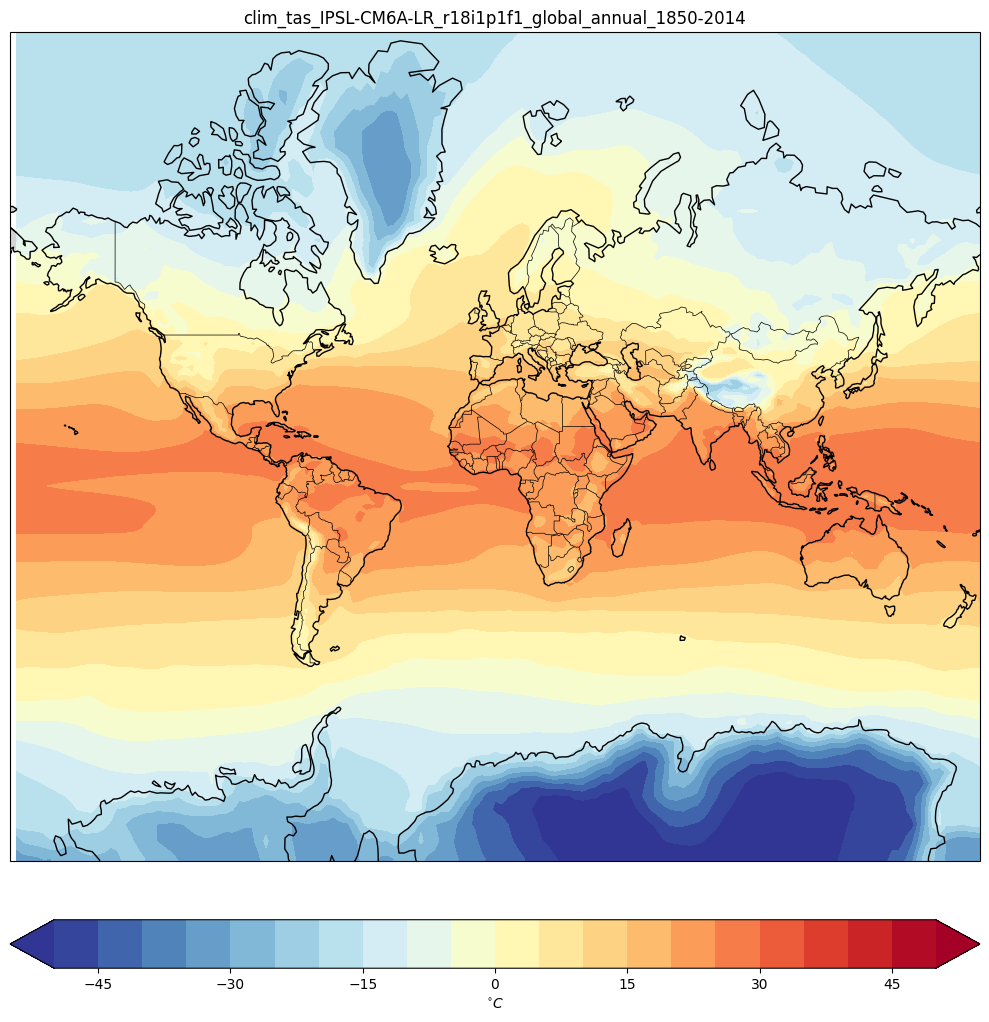

In [29]:
###
#Plotting climatology and standard deviation
###
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

lons, lats = np.meshgrid(xlon, ylat)
clevs = np.arange(-50, 55, 5)
cmap = plt.cm.RdYlBu_r

# Plot climatology (converted to Celsius)
cf = ax.contourf(
    lons, lats, clim[:, :] - 273.15, 
    clevs, cmap=cmap, extend='both', 
    transform=ccrs.PlateCarree()
)

cb = plt.colorbar(cf, orientation="horizontal", pad=0.05, ax=ax)
cb.set_label('$^{\circ}C$', fontsize=10)
plotname = 'clim_%s_%s_%s_%s_%s_%i-%i' % (variable, model, member, domain, season, iyr, fyr)
plt.title('%s' % (plotname), fontsize=12)
plt.tight_layout()
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()


In [8]:
'''##Save result in netCDF

ncout = Dataset(resultsDir+plotname+'.nc','w','NETCDF4'); 
ncout.createDimension('lon',nlon);
ncout.createDimension('lat',nlat);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = xlon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = ylat;
myvar = ncout.createVariable('clim','float32',('lat','lon'));myvar.setncattr('units',units);myvar[:] = clim;
myvar1=ncout.createVariable('std','float32',('lat','lon'));myvar1.setncattr('units',units);myvar1[:] = std;
ncout.close();
'''

"##Save result in netCDF\n\nncout = Dataset(resultsDir+plotname+'.nc','w','NETCDF4'); \nncout.createDimension('lon',nlon);\nncout.createDimension('lat',nlat);\nlonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = xlon;\nlatvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = ylat;\nmyvar = ncout.createVariable('clim','float32',('lat','lon'));myvar.setncattr('units',units);myvar[:] = clim;\nmyvar1=ncout.createVariable('std','float32',('lat','lon'));myvar1.setncattr('units',units);myvar1[:] = std;\nncout.close();\n"

In [30]:
###
##Computing anomalies
###
anom=np.zeros((nyr,nlat,nlon))
#anom=ma.masked_array(anom1,mask=field[0:nyr].mask)
for i in range(nyr):
    anom[i,:,:]=value[i,:,:]-clim



In [31]:
###
##Computing detrended anomalies using different detrending methods ( linear, quadratic, cubic)
#Info: #---------------------
#https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
#-----------------------------
###
##
deg=1
#deg=int(sys.argv[2])
anom_notrend=np.zeros((nyr,nlat,nlon))
xyears=np.arange(0,nyr,1)
for j in range(nlat):
    for i in range(nlon):
        if deg==1:
            poly=np.polyfit(xyears,anom[:,j,i],deg=1)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears+poly[1])
        elif deg==2:
            poly=np.polyfit(xyears,anom[:,j,i],deg=2)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears**2+poly[1]*xyears+poly[2])
        elif deg==3:
            poly=np.polyfit(xyears,anom[:,j,i],deg=3)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears**3+poly[1]*xyears**2+poly[2]*xyears+poly[3])


<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:28: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PC\AppData\Local\Temp\ipykernel_21416\1184959197.py:28: SyntaxWarning: invalid escape sequence '\c'
  cb.set_label('$^{\circ}C$', fontsize=10)


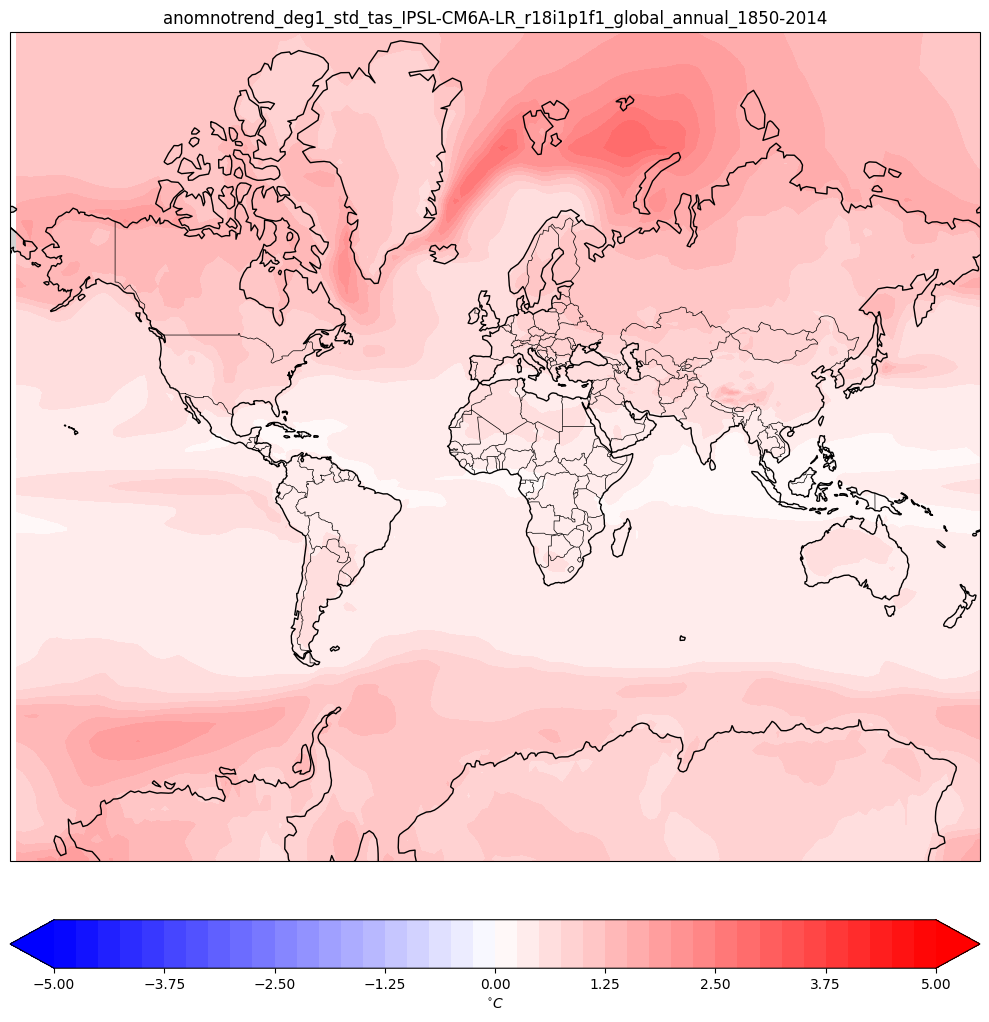

In [32]:
###
##Computing standard deviation of anomalies ( with or without trend)
###

stdnotrend=np.ma.std(anom_notrend,axis=0)
###
##Plotting standard deviation of anomalies
###
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

lons, lats = np.meshgrid(xlon, ylat)
clevs = np.arange(-5, 5.25, 0.25)
cmap = plt.cm.bwr

cf = ax.contourf(
    lons, lats, stdnotrend[:, :],
    clevs, cmap=cmap, extend='both',
    transform=ccrs.PlateCarree()
)

cb = plt.colorbar(cf, orientation="horizontal", pad=0.05, ax=ax)
cb.set_label('$^{\circ}C$', fontsize=10)
plotname = 'anomnotrend_deg%i_std_%s_%s_%s_%s_%s_%i-%i' % (deg, variable, model, member, domain, season, iyr, fyr)
plt.title('%s' % (plotname), fontsize=12)
plt.tight_layout()
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [12]:
'''
##Save result in netCDF

ncout = Dataset(resultsDir+plotname+'.nc','w','NETCDF4'); # using netCDF3 for output format
ncout.createDimension('lon',nlon);
ncout.createDimension('lat',nlat);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = xlon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = ylat;
myvar = ncout.createVariable('stdnotrend','float32',('lat','lon'));myvar.setncattr('units',units);myvar[:] = stdnotrend;
ncout.close();
'''

"\n##Save result in netCDF\n\nncout = Dataset(resultsDir+plotname+'.nc','w','NETCDF4'); # using netCDF3 for output format\nncout.createDimension('lon',nlon);\nncout.createDimension('lat',nlat);\nlonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = xlon;\nlatvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = ylat;\nmyvar = ncout.createVariable('stdnotrend','float32',('lat','lon'));myvar.setncattr('units',units);myvar[:] = stdnotrend;\nncout.close();\n"

In [13]:
###
## Computing spatial trend
###

trend=np.empty((nlat,nlon))
intercept=np.empty((nlat,nlon))
pvalue=np.empty((nlat,nlon))
rvalue=np.empty((nlat,nlon))
stderr=np.empty((nlat,nlon))
xd=np.array(range((nyr)))

for j in range(nlat):
    for i in range(nlon):
        yd=anom[:,j,i]
        par = stats.linregress(xd, yd)
        stderr[j,i]=par[4]
        pvalue[j,i]=par[3]
        rvalue[j,i]=par[2]
        intercept[j,i]=par[1]
        trend[j,i]=par[0]

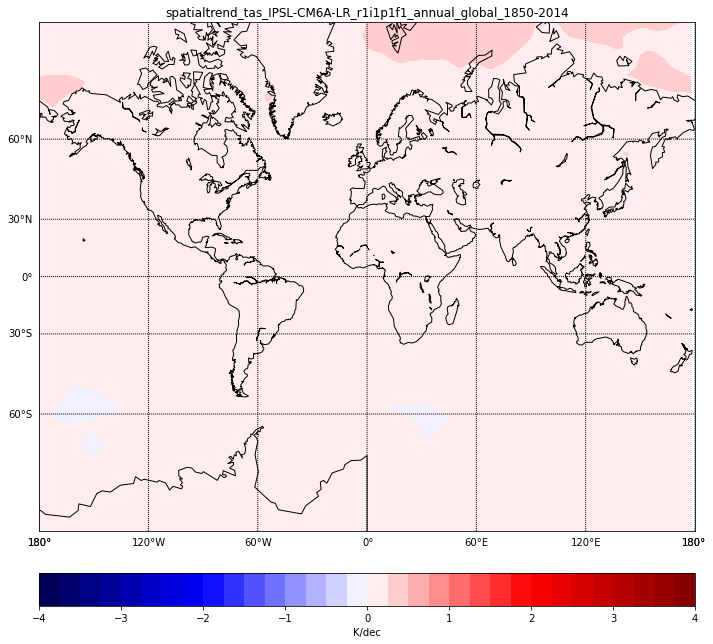

In [ ]:
###
##Plotting spatial trend
###

fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

lons, lats = np.meshgrid(xlon, ylat)
clevs = np.arange(-4.0, 4.25, 0.25)
cmap = plt.cm.seismic

cf = ax.contourf(
    lons, lats, trend * 10,
    clevs, cmap=cmap, extend='both',
    transform=ccrs.PlateCarree()
)

cb = plt.colorbar(cf, orientation="horizontal", pad=0.05, ax=ax)
cb.set_label('%s/dec' % (units), fontsize=10)
plotname = 'spatialtrend_%s_%s_%s_%s_%s_%i-%i' % (variable, model, member, season, domain, iyr, fyr)
plt.title('%s' % (plotname), fontsize=12)
plt.tight_layout()
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()


In [15]:

'''##Save result in netCDF

ncout = Dataset(resultsDir+plotname+'.nc','w','NETCDF4'); # using netCDF3 for output format
ncout.createDimension('lon',nlon);
ncout.createDimension('lat',nlat);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = xlon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = ylat;
myvar0 = ncout.createVariable('trend','float32',('lat','lon'));myvar0.setncattr('units',units+'/yr');myvar0[:] = trend;
myvar1 = ncout.createVariable('intercept','float32',('lat','lon'));myvar1.setncattr('units',units);myvar1[:] = intercept;
myvar2 = ncout.createVariable('rvalue','float32',('lat','lon'));myvar2.setncattr('units',units);myvar2[:] = rvalue;
myvar3 = ncout.createVariable('pvalue','float32',('lat','lon'));myvar3.setncattr('units',units);myvar3[:] = pvalue;
myvar4 = ncout.createVariable('stderr','float32',('lat','lon'));myvar4.setncattr('units',units+'/yr');myvar4[:] = stderr;
ncout.close();
'''

"##Save result in netCDF\n\nncout = Dataset(resultsDir+plotname+'.nc','w','NETCDF4'); # using netCDF3 for output format\nncout.createDimension('lon',nlon);\nncout.createDimension('lat',nlat);\nlonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = xlon;\nlatvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = ylat;\nmyvar0 = ncout.createVariable('trend','float32',('lat','lon'));myvar0.setncattr('units',units+'/yr');myvar0[:] = trend;\nmyvar1 = ncout.createVariable('intercept','float32',('lat','lon'));myvar1.setncattr('units',units);myvar1[:] = intercept;\nmyvar2 = ncout.createVariable('rvalue','float32',('lat','lon'));myvar2.setncattr('units',units);myvar2[:] = rvalue;\nmyvar3 = ncout.createVariable('pvalue','float32',('lat','lon'));myvar3.setncattr('units',units);myvar3[:] = pvalue;\nmyvar4 = ncout.createVariable('stderr','float32',('lat','lon'));myvar4.setncattr('units',units+'/yr');myvar4[:] = stderr;\nncout.close();\n"

In [16]:
####Spatial average------------------------------------
domain='global'

wgts = np.cos(np.deg2rad(ylat))

ts_anoms=np.ma.average(np.ma.average(anom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
ts_anoms_notrend=np.ma.average(np.ma.average(anom_notrend,axis=1,weights=wgts),axis=1)

#plotname='timeseries_anoms_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)

#plotname='timeseries_anoms_notrend_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)


xd=np.array(range(nyr))
par = stats.linregress(xd,ts_anoms)
trend=par[0]
intercept=par[1]
rvalue=par[2]
pvalue=par[3]
stderr=par[4]


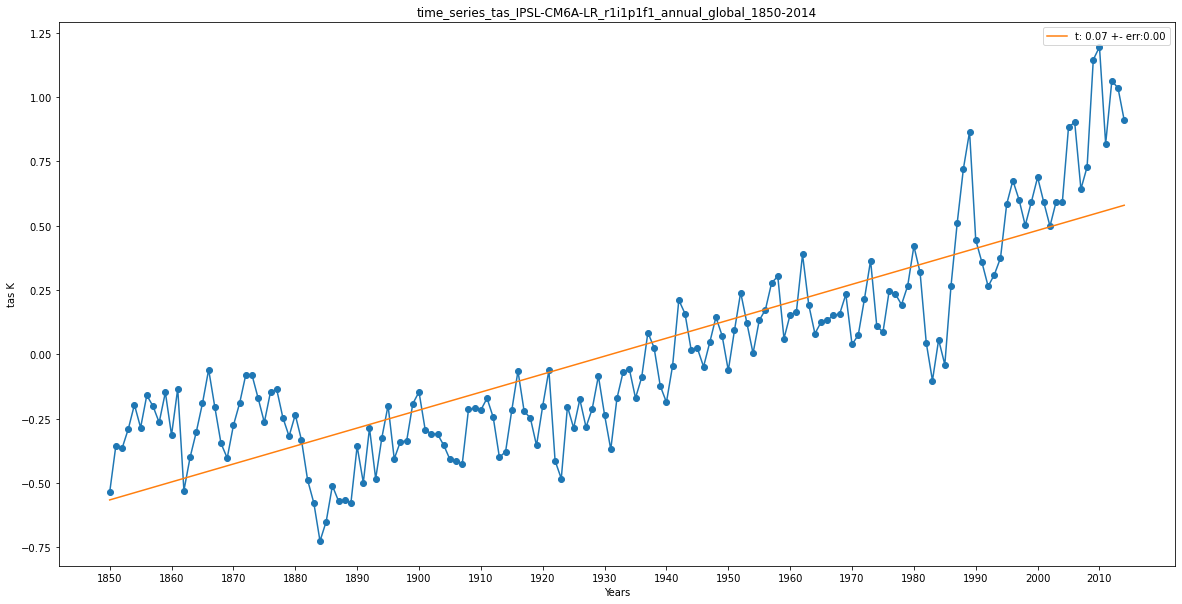

In [17]:
###
##Plotting time series
###

fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)
plt.ylabel('%s %s'%(variable,units))
plt.xlabel('Years')
plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o')
plt.plot(xdplot,trend*xdplot+intercept,label='t: %1.2f +- err:%1.2f'%(10*trend,10*stderr))
plt.legend()
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plotname='time_series_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,domain,iyr,fyr)
plt.title(plotname,fontsize=12)
plt.show()

###

In [18]:
###
##Selecting domain
###
#domain:EuroMed
#longitude: 10W-40E; latitude: 30N-50N
#in Python: x[70:89]; y[92:110]
###

domain='EuroMed'
xi=70;xf=89
xlon_dom=xlon[xi:xf]
nlon_dom=len(xlon_dom)
yi=92;yf=110
ylat_dom=ylat[yi:yf]
nlat_dom=len(ylat_dom)

#value_dom=value[:,yi:yf,xi:xf,:]
anom_dom=anom[:,yi:yf,xi:xf]
anom_notrend_dom=anom_notrend[:,yi:yf,xi:xf]

wgts = np.cos(np.deg2rad(ylat_dom))

ts_anoms_dom=np.ma.average(np.ma.average(anom_dom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
ts_anoms_notrend_dom=np.ma.average(np.ma.average(anom_notrend_dom,axis=1,weights=wgts),axis=1)

#plotname='timeseries_anoms_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)
#
#plotname='timeseries_anoms_notrend_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)


xd=np.array(range(nyr))
par_dom = stats.linregress(xd,ts_anoms_dom)
trend_dom=par_dom[0]
intercept_dom=par_dom[1]
rvalue_dom=par_dom[2]
pvalue_dom=par_dom[3]
stderr_dom=par_dom[4]


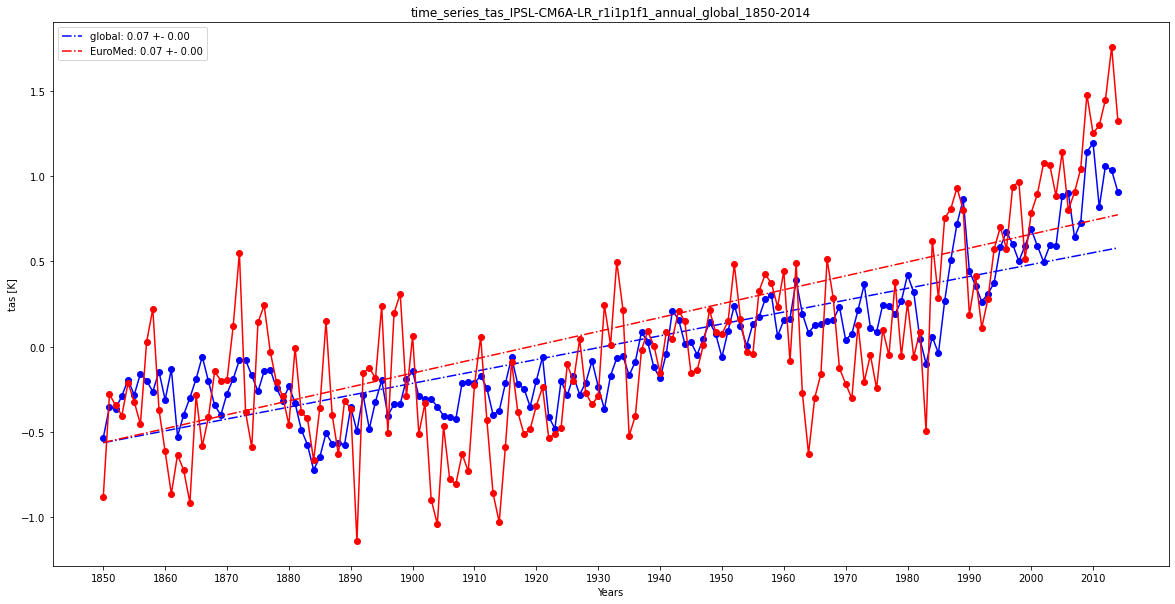

In [19]:

###
##Plotting time series
###

fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)
plt.ylabel('%s [%s]'%(variable,units))
plt.xlabel('Years')
plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.title(plotname,fontsize=12)
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o',color='blue')
plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='global'+': %1.2f +- %1.2f'%(10*trend,10*stderr))

plt.plot(xdplot,ts_anoms_dom,linestyle='-',marker='o',color='red')
plt.plot(xdplot,trend_dom*xdplot+intercept,linestyle='-.',color='red',label=domain+': %1.2f +- %1.2f'%(10*trend,10*stderr))

plt.legend()
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()